In [ ]:
# Hyperparameters
NOISE_TYPE = 'gauss'  # 'gauss' or 'poiss'
NOISE_LEVEL = 25      # 0-255 for Gaussian, 0-1 for Poisson
MAX_EPOCHS = 2000
LEARNING_RATE = 0.001
LR_STEP_SIZE = 1000
LR_GAMMA = 0.5
CHAN_EMBED = 48

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tqdm.notebook import tqdm
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DenoisingNetwork(nn.Module):
    """2-layer CNN for noise estimation"""
    def __init__(self, in_channels, hidden_channels=64, input_channel_multiplier=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels * input_channel_multiplier, hidden_channels, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_channels, in_channels, 1),
        )

    def forward(self, x):
        return self.layers(x)

def add_noise(image, noise_level):
    """Add synthetic noise to image"""
    if NOISE_TYPE == 'gauss':
        noisy = image + torch.randn_like(image) * (noise_level/255)
        return torch.clamp(noisy, 0, 1)

    if NOISE_TYPE == 'poiss':
        return torch.poisson(noise_level * image) / noise_level

    raise ValueError(f"Invalid noise type: {NOISE_TYPE}")

def create_downsampling_filters(channels, device):
    """Generate fixed downsampling kernels"""
    filter1 = torch.tensor([[[[0.5, 0.0], [0.0, 0.5]]]], device=device).repeat(channels, 1, 1, 1)
    filter2 = torch.tensor([[[[0.0, 0.5], [0.5, 0.0]]]], device=device).repeat(channels, 1, 1, 1)
    return filter1, filter2

def pair_downsample(image):
    """Create downsampled image pair using fixed kernels"""
    channels = image.shape[1]
    filter1, filter2 = create_downsampling_filters(channels, image.device)

    down1 = F.conv2d(image, filter1, stride=2, groups=channels)
    down2 = F.conv2d(image, filter2, stride=2, groups=channels)
    return down1, down2

def calculate_loss(noisy_image, model):
    """Compute combined residual and consistency loss"""
    # Residual loss components
    noisy1, noisy2 = pair_downsample(noisy_image)
    pred1 = noisy1 - model(noisy1)
    pred2 = noisy2 - model(noisy2)
    loss_res = 0.5 * (F.mse_loss(noisy1, pred2) + F.mse_loss(noisy2, pred1))

    # Consistency loss components
    denoised = noisy_image - model(noisy_image)
    denoised1, denoised2 = pair_downsample(denoised)
    loss_cons = 0.5 * (F.mse_loss(pred1, denoised1) + F.mse_loss(pred2, denoised2))

    return loss_res + loss_cons

def train_model(model, noisy_image, epochs=MAX_EPOCHS):
    """Training loop with learning rate scheduling"""
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, LR_STEP_SIZE, LR_GAMMA)

    progress = tqdm(range(epochs), desc="Training")
    for _ in progress:
        optimizer.zero_grad()
        loss = calculate_loss(noisy_image, model)
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress.set_postfix(loss=f"{loss.item():.4f}")

def evaluate_results(clean, noisy, denoised):
    """Calculate and display performance metrics"""
    mse_noisy = F.mse_loss(clean, noisy).item()
    mse_denoised = F.mse_loss(clean, denoised).item()

    psnr_noisy = 10 * np.log10(1 / mse_noisy)
    psnr_denoised = 10 * np.log10(1 / mse_denoised)

    print(f"PSNR Improvement: {psnr_denoised - psnr_noisy:.2f} dB")
    print(f"Final PSNR: {psnr_denoised:.2f} dB")

    return psnr_noisy, psnr_denoised

def plot_results(clean, noisy, denoised, psnr_noisy, psnr_denoised):
    """Visual comparison of images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    titles = ['Ground Truth', 'Noisy Input', 'Denoised Result']
    images = [clean, noisy, denoised]
    psnrs = ['', f'{psnr_noisy:.2f} dB', f'{psnr_denoised:.2f} dB']

    for ax, title, img, psnr in zip(axes, titles, images, psnrs):
        if img.shape[1] == 1:
            ax.imshow(img.cpu().squeeze().squeeze())
        else:
            ax.imshow(img.cpu().squeeze().permute(1, 2, 0))
        ax.set_title(title)
        ax.set_xlabel(psnr)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


def pixel_unshuffle(input, factor):
    """
    (n, c, h, w) ===> (n*factor^2, c, h/factor, w/factor)
    """
    batch_size, channels, in_height, in_width = input.size()

    out_height = in_height // factor
    out_width = in_width // factor

    input_view = input.contiguous().view(
        batch_size, channels, out_height, factor,
        out_width, factor)

    batch_size *= factor ** 2
    unshuffle_out = input_view.permute(0, 3, 5, 1, 2, 4).contiguous()
    return unshuffle_out.view(batch_size, channels, out_height, out_width)

def pixel_shuffle(input, factor):
    """
    (n*factor^2, c, h/factor, w/factor) ===> (n, c, h, w)
    """
    batch_size, channels, in_height, in_width = input.size()

    out_height = in_height * factor
    out_width = in_width * factor

    batch_size /= factor ** 2
    batch_size = int(batch_size)
    input_view = input.contiguous().view(
        batch_size, factor, factor, channels, in_height,
        in_width)

    unshuffle_out = input_view.permute(0, 3, 4, 1, 5, 2).contiguous()
    return unshuffle_out.view(batch_size, channels, out_height, out_width)

def calculate_loss_2(semi_image, noisy_image, model):
    """Compute combined residual and consistency loss"""
    # Residual loss components
    noisy1, noisy2 = pair_downsample(noisy_image)
    semi1, semi2 = pair_downsample(semi_image)
    pred1 = model(semi1)
    pred2 = model(semi2)
    loss_res = 0.5 * (F.mse_loss(noisy1, pred2) + F.mse_loss(noisy2, pred1))

    # Consistency loss components
    denoised = model(semi_image)
    denoised1, denoised2 = pair_downsample(denoised)
    loss_cons = 0.5 * (F.mse_loss(pred1, denoised1) + F.mse_loss(pred2, denoised2))

    return loss_res + loss_cons

def train_model_2(model, semi_image, noisy_image, epochs=MAX_EPOCHS):
    """Training loop with learning rate scheduling"""
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, LR_STEP_SIZE, LR_GAMMA)

    progress = tqdm(range(epochs), desc="Training")
    for _ in progress:
        optimizer.zero_grad()
        loss = calculate_loss_2(semi_image, noisy_image, model)
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress.set_postfix(loss=f"{loss.item():.4f}")

Using device: cuda


In [ ]:
import skimage
import skimage.io as io
from skimage.transform import resize
from skimage.color import gray2rgb

clean_img = torch.from_numpy(np.array(skimage.data.astronaut())).permute(2,0,1).unsqueeze(0).float().to(device)
clean_img = clean_img / 255
print(clean_img.shape)

noisy_img = add_noise(clean_img, NOISE_LEVEL).to(device)

torch.Size([1, 3, 512, 512])


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

PSNR Improvement: 7.70 dB
Final PSNR: 28.57 dB


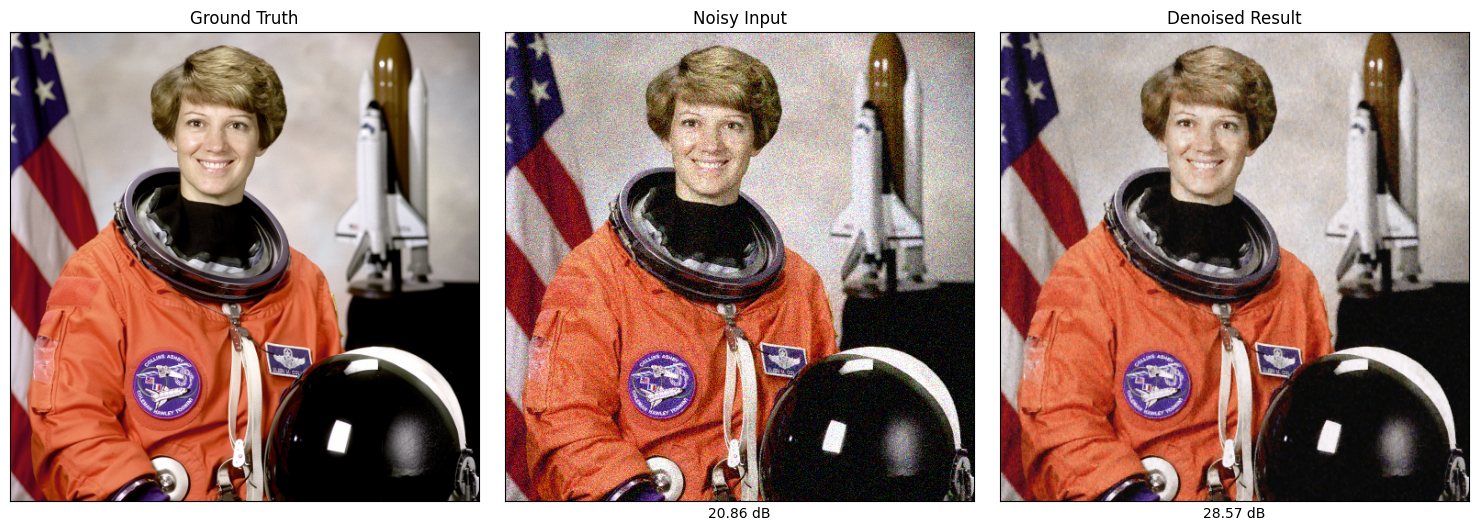

In [ ]:
model = DenoisingNetwork(clean_img.shape[1], CHAN_EMBED).to(device)
train_model(model, noisy_img, epochs=MAX_EPOCHS)

with torch.no_grad():
    denoised_img_1 = torch.clamp(noisy_img - model(noisy_img), 0, 1)

psnr_n, psnr_d = evaluate_results(clean_img, noisy_img, denoised_img_1)
plot_results(clean_img, noisy_img, denoised_img_1, psnr_n, psnr_d)

PSNR Improvement: 7.81 dB
Final PSNR: 28.67 dB


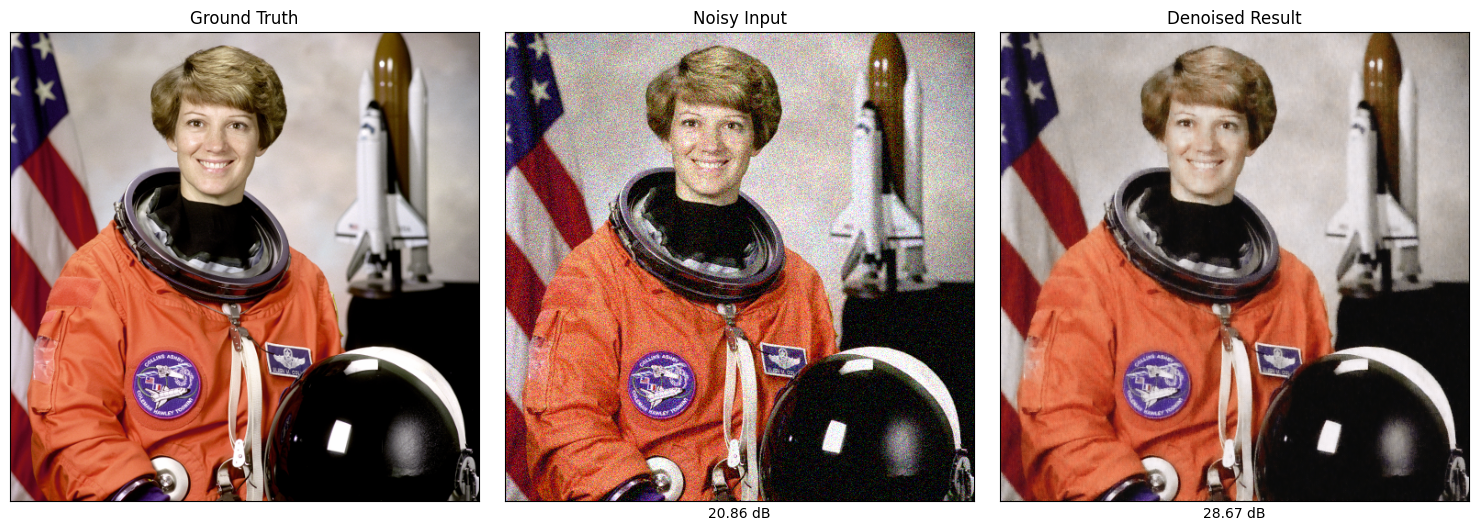

In [ ]:
with torch.no_grad():
    input = pixel_unshuffle(noisy_img, 2)
    pseudo1 = torch.clamp(input - model(input), 0, 1)
    pseudo1 = pixel_shuffle(pseudo1, 2)
    pseudo1 = torch.clamp(pseudo1 - model(pseudo1), 0, 1)

    input = pixel_unshuffle(noisy_img, 4)
    pseudo2 = torch.clamp(input - model(input), 0, 1)
    pseudo2 = pixel_shuffle(pseudo2, 4)
    pseudo2 = torch.clamp(pseudo2 - model(pseudo2), 0, 1)

    denoised_img_2 = (denoised_img_1 + pseudo1 + pseudo2) / 3

psnr_n, psnr_d = evaluate_results(clean_img, noisy_img, denoised_img_2)
plot_results(clean_img, noisy_img, denoised_img_2, psnr_n, psnr_d)

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

PSNR Improvement: 8.32 dB
Final PSNR: 29.18 dB


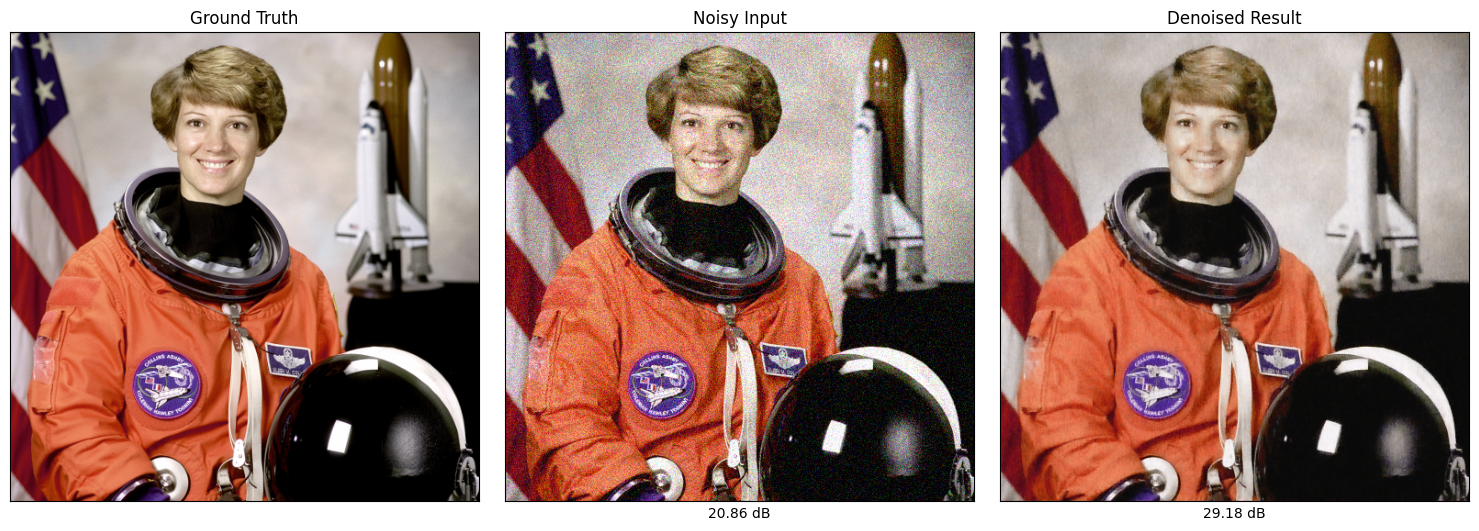

In [ ]:
model2 = DenoisingNetwork(clean_img.shape[1], CHAN_EMBED).to(device)
train_model_2(model2, denoised_img_2, noisy_img, epochs=2000)

with torch.no_grad():
    denoised_img_3 = torch.clamp(model2(denoised_img_2), 0, 1)

psnr_n, psnr_d = evaluate_results(clean_img, noisy_img, denoised_img_3)
plot_results(clean_img, noisy_img, denoised_img_3, psnr_n, psnr_d)